<img src="a20_a21_a22_jaccard.svg" style="text-align:center;width:50%;display:inline;"><img src="a20_a21_a22_partial.svg" style="text-align:center;width:50%;display:inline;">

# Parallelism

### Parallelism properties:
* __in syllables (isocolon)__ — adjacent phrases or clauses have equal syllable length. Helps consecutive statements cohere as a set. Example: 'They stand against us because we stand in their way.', 'The nation is sick. Trouble is in the land. Confusion all around.'
* __in stress patterns (iambic parameter)__ — alteranting stressed and unstressed syllables. Example: 'We do not want to fight. But we have fought before'
* __gramatical structure (parison)__ — parity among longer clauses from repetition. Example: 'That's the kind of soldiers they are That's the kind of people they are'
* __comparison (parallelism in argument)__ — Example: 'Yesterday climate change was a theory. Today climate change is the reality.'



In [38]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast
from tqdm import tqdm
import re

In [193]:
importlib.reload(utils)
connection = utils.connectDB()

In [194]:
FEATURE = "Parallelism"

In [195]:
# IMPORTANT: GPT data was corrected. Read the corrected GPT sheet NOT the database
gpt_df = pd.read_csv("corrected_GPT_min.csv")

In [196]:
# When this data is read in the majority_prop Type is incomaptible with the script downstream, so we just recreate this column each time
gpt_df['majority_prop'] = [list(utils.find_majority(ast.literal_eval(l))[0]) for l in gpt_df['all_properties']]

In [197]:
gpt_df.head()

,sentence_id,all_properties,feature_id,majority_prop
0,265,"[{'simple'}, {'simple'}, {'simple'}, {'simple'...",Aspect,[simple]
1,265,"[{'indicative'}, {'indicative'}, {'indicative'}]",Mood,[indicative]
2,265,[],Verb_choices,[]
3,265,"[{'subordinate'}, {'subordinate', 'adjective'}...",Modifying_clauses,"[adjective, subordinate]"
4,265,"[{'multiplying and embedding modifiers', 'sing...",Modifying_phrases,"[multiplying and embedding modifiers, single w..."


In [198]:
query = 'select * from annotations where annotator_id in (20,21,22) and completed=1;'
annotations = pd.read_sql(query, connection)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


### Format the human annotations like GPT for making comaprisons
This will roll the annotations up to the sentence level

In [199]:
a_20 = utils.annotationsToGPTFormat(20,annotations)
a_21 = utils.annotationsToGPTFormat(21,annotations)
a_22 = utils.annotationsToGPTFormat(22,annotations)

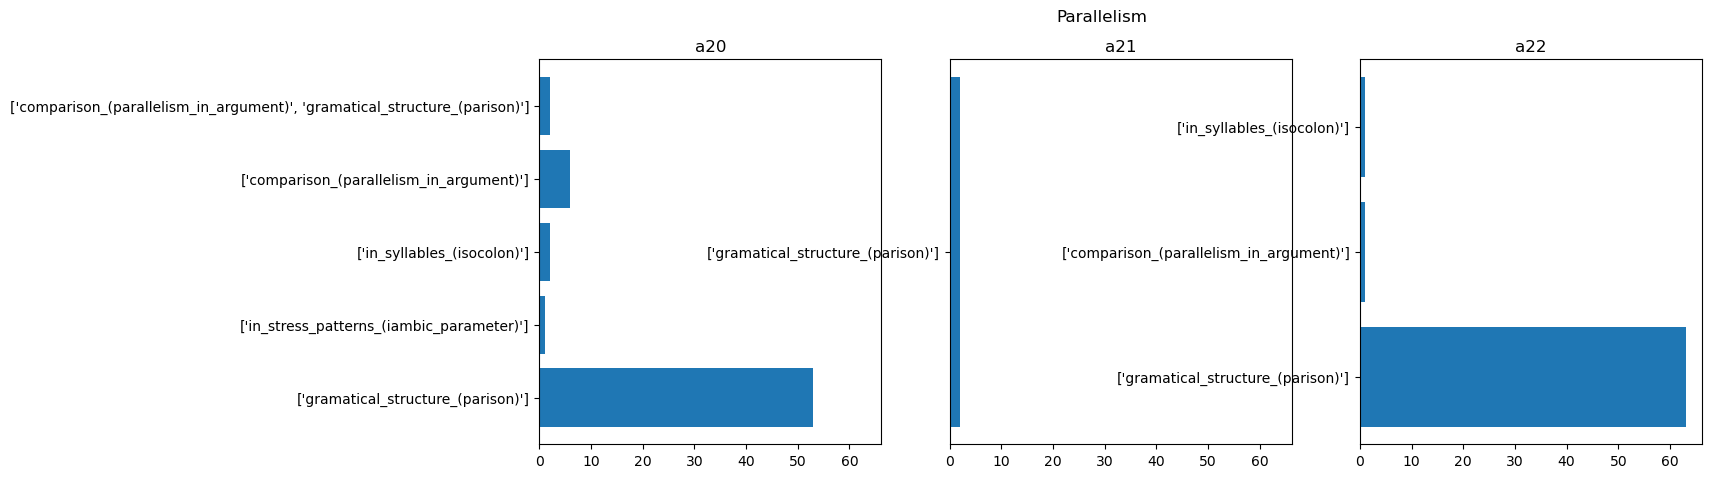

In [200]:
utils.plotPropertyDistributions(FEATURE,a_20,a_21,a_22)

In [201]:
features_gpt = list(gpt_df.groupby('feature_id').agg(list).reset_index()['feature_id'])
idx_gpt = features_gpt.index(FEATURE)
gpt_df_properties = gpt_df.groupby('feature_id').agg(list).reset_index().loc[idx_gpt][['all_properties','sentence_id']]
cGPT = Counter([str(utils.find_majority(ast.literal_eval(l))[0]) for l in gpt_df_properties['all_properties']])

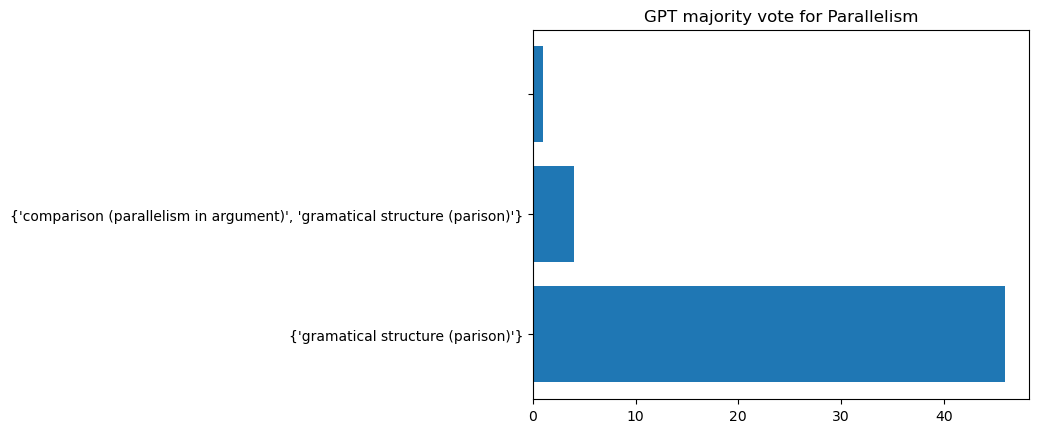

In [202]:
plt.barh(list(cGPT.keys()),list(cGPT.values()))
plt.title("GPT majority vote for "+FEATURE)
plt.show()

### Find all the sentences where there is agreement on the majority property



In [203]:
majority_property = 'gramatical_structure_(parison)'

In [204]:
a_20_sent = set(a_20[a_20['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
a_21_sent = set(a_21[a_21['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
a_22_sent = set(a_22[a_22['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
gpt_df_sent = set(gpt_df[gpt_df['majority_prop'].apply(lambda x: x == [majority_property])]['sentence_id'])

In [205]:
all_agreed_sentences = a_20_sent.intersection(a_21_sent,a_22_sent,gpt_df_sent)

In [206]:
len(all_agreed_sentences)

0

### Find all the sentences (and the respective annotations) that are not in the agreed sentences list

### Find all sentences

In [207]:
query = 'SELECT id, technique, text FROM ebdb.sample_sentences;'
non_agreed_sentences = pd.read_sql(query, connection)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [17]:
non_agreed_sentences['feature_id'] = FEATURE
non_agreed_sentences['props_a20'] = ''
non_agreed_sentences['props_a21'] = ''
non_agreed_sentences['props_a22'] = ''
non_agreed_sentences['props_gpt'] = ''

In [18]:
non_agreed_sentences = non_agreed_sentences[['id', 'technique', 'text', 'feature_id', 'props_a20', 'props_a21', 'props_a22', 'props_gpt']]
non_agreed_sentences = non_agreed_sentences.rename(columns={'id':'sentence_id'})

In [19]:
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Parallelism,,,,
1,11,[0 8],We are simply asked to take the pope’s word fo...,Parallelism,,,,
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Parallelism,,,,
3,16,[0],"According to Breitbart, “Sellner, who describe...",Parallelism,,,,
4,23,[0],“This is a clear violation of the Senate Ethic...,Parallelism,,,,


In [210]:
utils.fillInAnnotations(non_agreed_sentences,a_20,a_21,a_22,gpt_df,FEATURE)

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1_x,gpt_props1_x,res2_x,...,gpt_props3_x,props_a_majority,props_gpt_majority,ann_gpt_agreemnt,res1_y,gpt_props1_y,res2_y,gpt_props2_y,res3_y,gpt_props3_y
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Parallelism,[gramatical_structure_(parison)],NaN,[gramatical_structure_(parison)],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",...,[],[],['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison'],"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison'],"``` \n{\n ""Properties"": [""in syllables (isoco...",['in_syllables_(isocolon)']
1,11,[0 8],We are simply asked to take the pope’s word fo...,Parallelism,[in_stress_patterns_(iambic_parameter)],[gramatical_structure_(parison)],NaN,"{\n ""Properties"": [\n ""grammatical structu...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",...,[],[],['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammar structure"", ""comp...","['grammar_structure', 'comparison']","{\n ""Properties"": [""grammatical structure""],\...",['grammatical_structure']
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Parallelism,[in_syllables_(isocolon)],NaN,NaN,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""in stress patterns (iambi...",...,['comparison'],[],['grammatical_structure_(parison)'],-1,timeout,[],"{\n ""Properties"": [""comparison""],\n ""Exp...",['comparison'],"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison']
3,16,[0],"According to Breitbart, “Sellner, who describe...",Parallelism,NaN,NaN,NaN,"{\n ""Properties"": [\n ""grammatical structu...",['grammatical_structure_(parison)'],"```\n\n\n {\n ""Properties"": [""...",...,['comparison'],[],['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)']
4,23,[0],“This is a clear violation of the Senate Ethic...,Parallelism,[in_syllables_(isocolon)],NaN,[gramatical_structure_(parison)],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],timeout,...,['grammatical_structure'],[],['grammatical_structure_(parison)'],-1,timeout,[],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,14484,[],"They noted Haig's LinkedIn page, which says he...",Parallelism,NaN,NaN,NaN,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",...,['grammatical_structure'],[],['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison'],"{\n ""Properties"": [""grammatical structure""],\...",['grammatical_structure'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)']
353,14506,[],"When asked about the threats, Haig said, “I’ve...",Parallelism,NaN,NaN,NaN,"{\n ""Properties"": [""in syllables (isocolon)""]...",['in_syllables_(isocolon)'],"{\n ""Properties"": [""grammatical structure (pa...",...,['grammatical_structure_(parison)'],[],['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""grammatical structure""],\...",['grammatical_structure'],"{\n ""Properties"": [""grammatical structure""],\...",['grammatical_structure'],"{\n ""Pro

In [21]:
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

### Find rows with missing GPT responses

In [22]:
to_reprompt = non_agreed_sentences[non_agreed_sentences['props_gpt']=='']

In [23]:
print(len(to_reprompt))
to_reprompt.head()

306


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Parallelism,[gramatical_structure_(parison)],,[gramatical_structure_(parison)],
1,11,[0 8],We are simply asked to take the pope’s word fo...,Parallelism,[in_stress_patterns_(iambic_parameter)],[gramatical_structure_(parison)],,
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Parallelism,[in_syllables_(isocolon)],,,
3,16,[0],"According to Breitbart, “Sellner, who describe...",Parallelism,,,,
4,23,[0],“This is a clear violation of the Senate Ethic...,Parallelism,[in_syllables_(isocolon)],,[gramatical_structure_(parison)],


### Reprompt GPT 3 times and merge with non_agreed_sentences

In [24]:
# model = "gpt-3.5-turbo-0301"
# model = "gpt-3.5-turbo-0613"
# model = "gpt-3.5-turbo-1106"
# model = "gpt-4"

In [44]:
import GPT
importlib.reload(GPT)
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results/utils.py'>

In [45]:
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
print(len(non_agreed_sentences))
to_reprompt = non_agreed_sentences

357


In [46]:
def parseRes(x):
    try:
        result = utils.parseGPTresponse(x)[1][0]
    except:
        result = []
    return result

for i in range(1,4):
    responses = []
    gpt = GPT.GPT("gpt-3.5-turbo-1106")

    for row in tqdm(to_reprompt.iterrows()):
        sentence = row[1]['text']
        feature = row[1]['feature_id']
        sid = row[1]['sentence_id']
        promt, response = gpt.get_gpt_response(sentence,feature,sid)
        responses.append([sid, response])

    df = pd.DataFrame(responses, columns=['sentence_id','res'+str(i)])
    df['gpt_props'+str(i)] = df['res'+str(i)].apply(parseRes)
    non_agreed_sentences = non_agreed_sentences.merge(df, how='outer',on='sentence_id')
    non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

    print(f"There were {len(gpt.errors)} errors in round {i}.")

357it [1:19:19, 13.33s/it]


There were 14 errors in round 1.


357it [23:23,  3.93s/it]


There were 3 errors in round 2.


357it [41:22,  6.96s/it]


There were 7 errors in round 3.


In [162]:
# Sanity check
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1_x,gpt_props1_x,res2_x,...,gpt_props3_x,props_a_majority,props_gpt_majority,ann_gpt_agreemnt,res1_y,gpt_props1_y,res2_y,gpt_props2_y,res3_y,gpt_props3_y
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Parallelism,['grammatical_structure_(parison)'],NaN,['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",...,[],[],['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison'],"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison'],"``` \n{\n ""Properties"": [""in syllables (isoco...",['in_syllables_(isocolon)']
1,11,[0 8],We are simply asked to take the pope’s word fo...,Parallelism,['in_stress_patterns_(iambic_parameter)'],['grammatical_structure_(parison)'],NaN,"{\n ""Properties"": [\n ""grammatical structu...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",...,[],[],['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammar structure"", ""comp...","['grammar_structure', 'comparison']","{\n ""Properties"": [""grammatical structure""],\...",['grammatical_structure']
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Parallelism,['in_syllables_(isocolon)'],NaN,NaN,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""in stress patterns (iambi...",...,['comparison'],[],['grammatical_structure_(parison)'],-1,timeout,[],"{\n ""Properties"": [""comparison""],\n ""Exp...",['comparison'],"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison']
3,16,[0],"According to Breitbart, “Sellner, who describe...",Parallelism,NaN,NaN,NaN,"{\n ""Properties"": [\n ""grammatical structu...",['grammatical_structure_(parison)'],"```\n\n\n {\n ""Properties"": [""...",...,['comparison'],[],['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)']
4,23,[0],“This is a clear violation of the Senate Ethic...,Parallelism,['in_syllables_(isocolon)'],NaN,['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],timeout,...,['grammatical_structure'],[],['grammatical_structure_(parison)'],-1,timeout,[],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)']


### Correct the GPT properties to match the annotators. 
GPT doesn't always list the properties as they appear even though it is instructed to do so.

In [56]:
l1 = set(non_agreed_sentences['gpt_props1_y'].unique())
l2 = set(non_agreed_sentences['gpt_props2_y'].unique())
l3 = set(non_agreed_sentences['gpt_props3_y'].unique())

In [57]:
l1.union(l2,l3)

{"['comparison']",
 "['comparison_(parallelism_in_argument)']",
 "['gradation']",
 "['grammar_structure', 'comparison']",
 "['grammarical_structure_(parison)']",
 "['grammatical_structure', 'comparison']",
 "['grammatical_structure']",
 "['grammatical_structure_(parison)', 'comparison_(parallelism_in_argument)']",
 "['grammatical_structure_(parison)', 'in_syllables_(isocolon)']",
 "['grammatical_structure_(parison)']",
 "['in_stress_patterns_(iambic_parameter)']",
 "['in_syllables', 'grammatical_structure']",
 "['in_syllables']",
 "['in_syllables_(isocolon)', 'comparison_(parallelism_in_argument)']",
 "['in_syllables_(isocolon)', 'grammatical_structure_(parison)', 'comparison_(parallelism_in_argument)']",
 "['in_syllables_(isocolon)', 'grammatical_structure_(parison)']",
 "['in_syllables_(isocolon)', 'in_stress_patterns_(iambic_parameter)']",
 "['in_syllables_(isocolon)']",
 "['parison']",
 '[]'}

In [148]:
importlib.reload(GPT)
gpt = GPT.GPT("gpt-3.5-turbo-1106")

In [211]:
# Correct the GPT properties to match the annotators
def mapProp(x):
    if type(x) == str:
        return [gpt.mapToProperty(elem,FEATURE) for elem in ast.literal_eval(x)]
    else:
        return [gpt.mapToProperty(elem,FEATURE) for elem in x]

for col in ['gpt_props1_x','gpt_props1_y','gpt_props2_x','gpt_props2_y','gpt_props3_x','gpt_props3_y']:
    non_agreed_sentences[col] = non_agreed_sentences[col].apply(lambda x: mapProp(x))

In [215]:
non_agreed_sentences.head()

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1_x,gpt_props1_x,res2_x,...,gpt_props3_x,props_a_majority,props_gpt_majority,ann_gpt_agreemnt,res1_y,gpt_props1_y,res2_y,gpt_props2_y,res3_y,gpt_props3_y
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Parallelism,['gramatical_structure_(parison)'],NaN,['gramatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",...,[],"['gramatical_structure_(parison)'], nan, ['gra...",['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison_(parallelism_in_argument)'],"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison_(parallelism_in_argument)'],"``` \n{\n ""Properties"": [""in syllables (isoco...",['in_syllables_(isocolon)']
1,11,[0 8],We are simply asked to take the pope’s word fo...,Parallelism,['in_stress_patterns_(iambic_parameter)'],['gramatical_structure_(parison)'],NaN,"{\n ""Properties"": [\n ""grammatical structu...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",...,[],"['in_stress_patterns_(iambic_parameter)'], ['g...",['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammar structure"", ""comp...","['grammatical_structure_(parison)', 'compariso...","{\n ""Properties"": [""grammatical structure""],\...",['grammatical_structure_(parison)']
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Parallelism,['in_syllables_(isocolon)'],NaN,NaN,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""in stress patterns (iambi...",...,['comparison_(parallelism_in_argument)'],"['in_syllables_(isocolon)'], nan, nan",['grammatical_structure_(parison)'],-1,timeout,[],"{\n ""Properties"": [""comparison""],\n ""Exp...",['comparison_(parallelism_in_argument)'],"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison_(parallelism_in_argument)']
3,16,[0],"According to Breitbart, “Sellner, who describe...",Parallelism,NaN,NaN,NaN,"{\n ""Properties"": [\n ""grammatical structu...",['grammatical_structure_(parison)'],"```\n\n\n {\n ""Properties"": [""...",...,['comparison_(parallelism_in_argument)'],"nan, nan, nan",['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)']
4,23,[0],“This is a clear violation of the Senate Ethic...,Parallelism,['in_syllables_(isocolon)'],NaN,['gramatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],timeout,...,['grammatical_structure_(parison)'],"['in_syllables_(isocolon)'], nan, ['gramatical...",['grammatical_structure_(parison)'],-1,timeout,[],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)']


In [142]:
# gpt.featuresDict
# gpt.propertiesDict

In [213]:
# get the majority vote from the annotators (props_a20, props_a21, props_a22)
# What to do when there is no majority? NA?

In [214]:
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

In [219]:
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

In [221]:
non_agreed_sentences[['props_a20','props_a21','props_a22']] = non_agreed_sentences[['props_a20','props_a21','props_a22']].fillna('[]')

non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a20']+", "+\
                                           non_agreed_sentences['props_a21']+", "+\
                                           non_agreed_sentences['props_a22'] #.apply(utils.find_majority)

def convert(x):
    # try: result = ast.literal_eval(x)
    # except: result = [[]]
    # return result
    return list(ast.literal_eval(x))


    

non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(convert)
non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(lambda l: utils.find_majority(l)[0])

In [236]:
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

In [165]:
# get the majority vote from the reprompt (gpt_props1, gpt_props2, gpt_props3)

def listOfLists(*lists):
    new_list = []
    for l in lists:
        if len(l):
            new_list.append(l)
    return new_list

non_agreed_sentences['props_gpt_list'] = non_agreed_sentences.apply(lambda x: listOfLists(x['gpt_props1_x'],
                                                                                          x['gpt_props2_x'],
                                                                                          x['gpt_props3_x']), axis=1)

def find_majority(row):
    if len(row.props_gpt_list):
        return utils.find_majority(row.props_gpt_list)[0]
    else:
        return row.props_gpt_majority
    
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences.apply(lambda x: find_majority(x),axis=1)
non_agreed_sentences = non_agreed_sentences.drop(['props_gpt_list'], axis=1)


# non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['gpt_props1_y']+", "+\
#                                            non_agreed_sentences['gpt_props2_y']+", "+\
#                                            non_agreed_sentences['gpt_props3_y']

# def convert(x):
#     try: result = list(ast.literal_eval(x))
#     except: result = [[]]
#     return result

# non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(convert)
# non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(lambda l: utils.find_majority(l)[0])

In [29]:
# Merge the previous gpt props with the newly reprompted ones into a single column
def convert(x):
    try: 
        result = list(ast.literal_eval(x))
        result = [r.replace(" ","_") for r in result]
    except: 
        result = []
    return result

non_agreed_sentences['props_gpt'] = non_agreed_sentences['props_gpt'].apply(convert)
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'] + non_agreed_sentences['props_gpt']
non_agreed_sentences = non_agreed_sentences.drop(['props_gpt'], axis=1)


### Calculate agreement between annotator majority and GPT majority

* One issue is that when there is no majority the last item is selected
* Also, `gramatical` was misspelled. Hense the following correction.

In [230]:
non_agreed_sentences['props_a_majority'].unique()

array(["['gramatical_structure_(parison)']",
       "['in_stress_patterns_(iambic_parameter)']", '[]',
       "['in_syllables_(isocolon)']",
       "['comparison_(parallelism_in_argument)']"], dtype=object)

In [231]:
pros_dict = {
        "['gramatical_structure_(parison)']":"['grammatical_structure_(parison)']",
        "['in_stress_patterns_(iambic_parameter)']":"['in_stress_patterns_(iambic_parameter)']", 
        '[]':'[]',
        "['in_syllables_(isocolon)']":"['in_syllables_(isocolon)']",
        "['comparison_(parallelism_in_argument)']":"['comparison_(parallelism_in_argument)']"
}
non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(lambda x: pros_dict[x])

In [232]:
non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)

In [234]:
# save the final version
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

In [235]:
# Sanity check
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
print(len(non_agreed_sentences))
non_agreed_sentences.head()

357


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1_x,gpt_props1_x,res2_x,...,gpt_props3_x,props_a_majority,props_gpt_majority,ann_gpt_agreemnt,res1_y,gpt_props1_y,res2_y,gpt_props2_y,res3_y,gpt_props3_y
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Parallelism,['gramatical_structure_(parison)'],[],['gramatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",...,[],['grammatical_structure_(parison)'],['grammatical_structure_(parison)'],1,"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison_(parallelism_in_argument)'],"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison_(parallelism_in_argument)'],"``` \n{\n ""Properties"": [""in syllables (isoco...",['in_syllables_(isocolon)']
1,11,[0 8],We are simply asked to take the pope’s word fo...,Parallelism,['in_stress_patterns_(iambic_parameter)'],['gramatical_structure_(parison)'],[],"{\n ""Properties"": [\n ""grammatical structu...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",...,[],['in_stress_patterns_(iambic_parameter)'],['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammar structure"", ""comp...","['grammatical_structure_(parison)', 'compariso...","{\n ""Properties"": [""grammatical structure""],\...",['grammatical_structure_(parison)']
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Parallelism,['in_syllables_(isocolon)'],[],[],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""in stress patterns (iambi...",...,['comparison_(parallelism_in_argument)'],[],['grammatical_structure_(parison)'],-1,timeout,[],"{\n ""Properties"": [""comparison""],\n ""Exp...",['comparison_(parallelism_in_argument)'],"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison_(parallelism_in_argument)']
3,16,[0],"According to Breitbart, “Sellner, who describe...",Parallelism,[],[],[],"{\n ""Properties"": [\n ""grammatical structu...",['grammatical_structure_(parison)'],"```\n\n\n {\n ""Properties"": [""...",...,['comparison_(parallelism_in_argument)'],[],['grammatical_structure_(parison)'],-1,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)']
4,23,[0],“This is a clear violation of the Senate Ethic...,Parallelism,['in_syllables_(isocolon)'],[],['gramatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],timeout,...,['grammatical_structure_(parison)'],['in_syllables_(isocolon)'],['grammatical_structure_(parison)'],-1,timeout,[],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)']


# FIX ALL THE ERRORS
(Majorities are calculated at the list level, not the item level for both annotators and GPT)

In [11]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast
from tqdm import tqdm
import re

In [29]:
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results/utils.py'>

In [13]:
FEATURE = "Parallelism"

In [30]:
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
non_agreed_sentences = pd.read_csv("Inter-annotator agreement - Parallelism.csv")

def parseRes(x):
    try:
        result = utils.parseGPTresponse(x)[1][0]
    except:
        result = []
    return result

for i in range(1,4):
    non_agreed_sentences['gpt_props'+str(i)] = non_agreed_sentences['res'+str(i)].apply(parseRes)

def listOfLists(*lists):
    new_list = []
    for l in lists:
        if len(l):
            new_list.append(l)
    return new_list

non_agreed_sentences['props_gpt_list'] = non_agreed_sentences.apply(lambda x: listOfLists(x['gpt_props1'],
                                                                                          x['gpt_props2'],
                                                                                          x['gpt_props3']), axis=1)
def find_majority(row):
    if len(row.props_gpt_list):
        return utils.find_majority(row.props_gpt_list)[0]
    else:
        return row.props_gpt_majority
    
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences.apply(lambda x: find_majority(x),axis=1)
non_agreed_sentences = non_agreed_sentences.drop(['props_gpt_list'], axis=1)

# # the old GPT majorities still have spaces. Remove spaces
def replaceSpaces(x):
    if type(x) == str:
        x = ast.literal_eval(x)
    x = [i.replace(" ","_") for i in x]
    return x

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(replaceSpaces)
non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)

non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")


In [31]:
non_agreed_sentences.loc[9]

sentence_id                                                          54
technique                                                           [0]
text                  She said Thursday regarding Ms. Ford: "I belie...
feature_id                                                  Parallelism
props_a20                                                           NaN
props_a21                                                           NaN
props_a22                           ['grammatical_structure_(parison)']
res1                  {\n  "Properties": [\n    "comparison (paralle...
gpt_props1                     ['comparison_(parallelism_in_argument)']
res2                  {\n  "Properties": ["grammatical structure (pa...
gpt_props2                          ['grammatical_structure_(parison)']
res3                  {\n  "Properties": ["grammatical structure (pa...
gpt_props3                          ['grammatical_structure_(parison)']
props_a_majority                                                

In [18]:
non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)
FEATURE = "Parallelism"

In [24]:
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

In [32]:
non_agreed_sentences

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1,gpt_props1,res2,gpt_props2,res3,gpt_props3,props_a_majority,props_gpt_majority,ann_gpt_agreemnt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Parallelism,['grammatical_structure_(parison)'],NaN,['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],timeout,[],[],['grammatical_structure_(parison)'],-1
1,11,[0 8],We are simply asked to take the pope’s word fo...,Parallelism,['in_stress_patterns_(iambic_parameter)'],['grammatical_structure_(parison)'],NaN,"{\n ""Properties"": [\n ""grammatical structu...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [],\n ""Explanation"": ""The ...",[],[],['grammatical_structure_(parison)'],-1
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Parallelism,['in_syllables_(isocolon)'],NaN,NaN,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""in stress patterns (iambi...",['in_stress_patterns_(iambic_parameter)'],"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison'],[],['grammatical_structure_(parison)'],-1
3,16,[0],"According to Breitbart, “Sellner, who describe...",Parallelism,NaN,NaN,NaN,"{\n ""Properties"": [\n ""grammatical structu...",['grammatical_structure_(parison)'],"```\n\n\n {\n ""Properties"": [""...",['grammatical_structure'],"{\n ""Properties"": [""comparison""],\n ""Explana...",['comparison'],[],['grammatical_structure_(parison)'],-1
4,23,[0],“This is a clear violation of the Senate Ethic...,Parallelism,['in_syllables_(isocolon)'],NaN,['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],timeout,[],"{\n ""Properties"": [""grammatical structure""],\...",['grammatical_structure'],[],['grammatical_structure_(parison)'],-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,14484,[],"They noted Haig's LinkedIn page, which says he...",Parallelism,NaN,NaN,NaN,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure""],\...",['grammatical_structure'],[],['grammatical_structure_(parison)'],-1
353,14506,[],"When asked about the threats, Haig said, “I’ve...",Parallelism,NaN,NaN,NaN,"{\n ""Properties"": [""in syllables (isocolon)""]...",['in_syllables_(isocolon)'],"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"``` \n{\n ""Properties"": [""grammatical structu...",['grammatical_structure_(parison)'],[],['grammatical_structure_(parison)'],-1
354,14878,[],"In 1953, the CIA was in the process of develop...",Parallelism,['grammatical_structure_(parison)'],NaN,NaN,NaN,[],NaN,[],NaN,[],[],['grammatical_structure_(parison)'],-1
355,15168,[],"“If code is speech, the constitutional contrad...",Parallelism,NaN,NaN,NaN,"{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],"{\n ""Properties"": [""grammatical structure (pa...","['grammatical_structure_(parison)', 'compariso...","{\n ""Properties"": [""grammatical structure (pa...",['grammatical_structure_(parison)'],[],['grammatical_structure_(parison)'],-1
